In [2]:
%load_ext autoreload
%autoreload 2
from sys import path
from os import getcwd
path.append(getcwd() + "/..")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import simplegrad.algo.optimize as sgo
import simplegrad as sg
from graphviz import Digraph
import graphviz
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def bukin_function(x, y):
    return 100 * (abs(y - 0.01 * (x ** 2)) ** (1/2)) + 0.01 * abs(x + 10)


In [4]:
def drawHeatmap(f, center, points_num_axis = 2* 1e2, delta = 1, ax=None):
    points_num_axis = int(points_num_axis)
    grid = np.mgrid[
           center[0] - delta:center[0] + delta:(points_num_axis* 1j),
           center[1] - delta:center[1] + delta:(points_num_axis* 1j)]
    allPoints = grid.copy().reshape((2, points_num_axis * points_num_axis))
    result = f(allPoints[0, :], allPoints[1, :]).reshape((points_num_axis, points_num_axis)).T[::-1,::1]
    if ax is None:
        plt.figure(figsize=(8, 8))
    sns.heatmap(result, cbar=False, ax=ax, robust=True)
    if ax is None:
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Function heatmap [{np.min(grid[0])}, {np.max(grid[0])}]x[{np.min(grid[1])}, {np.max(grid[1])}]")
    else:
        ax.set_xticks([])
        ax.set_yticks([])

def drawPath(points, center, minimum, points_num_axis = 2* 1e2, delta = 1, ax=None, color='teal', label=None):
    points_transformed = []
    grid = np.mgrid[
           center[0] - delta:center[0] + delta:(points_num_axis* 1j),
           center[1] - delta:center[1] + delta:(points_num_axis* 1j)]
    for point in [minimum] + points:
        x = (point[0] - np.min(grid[0])) / (2 * delta) * points_num_axis
        y = (1 - (point[1] - np.min(grid[1])) / (2 * delta)) * points_num_axis
        points_transformed.append((x, y))
    sns.scatterplot(x=points_transformed[0][0], y = [points_transformed[0][1]], color='crimson', ax=ax)
    points_transformed = np.array(points_transformed[1:])
    if len(points_transformed) > 0:
        sns.lineplot(x=points_transformed[:,0], y=points_transformed[:,1], color=color, alpha=0.6, sort=False, ax=ax, linewidth=4, label=label)

In [5]:
x, y = sg.Variable(-11), sg.Variable(2)
history = []
loss = []
f = bukin_function(x, y)
f.forward()
f.backward()
optimizer = sgo.Adam(model=f, variables=[x, y], lr=1e-2)

In [6]:
for i in tqdm(range(10000)):
    history.append((x.scalar, y.scalar))
    loss.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
(x.scalar, y.scalar)


  0%|          | 0/10000 [00:00<?, ?it/s]

(-11.61832761051427, 1.3329842661119338)

In [7]:
x, y = sg.Variable(-11), sg.Variable(2)
f = abs(x * x) + abs(y)
f.forward()
f.backward()
optimizer = sgo.GD(model=f, variables=[x, y], lr=1e-2)
for i in tqdm(range(10000)):
    history.append((x.scalar, y.scalar))
    loss.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
(x.scalar, y.scalar)


  0%|          | 0/10000 [00:00<?, ?it/s]

(-2.0051626668895737e-87, -1.6410484082740595e-15)

In [8]:
a = 1
b = 100
def rosenbrockFunction(x, y):
    return (a - x) ** 2 + b * (y - (x ** 2)) ** 2

minimum = (a, a * a)
center = (0, 1)
delta = 2

In [9]:
def boothFunction(x, y):
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2
def rosenbrockFunction(x, y):
    return (a - x) ** 2 + b * (y - (x ** 2)) ** 2

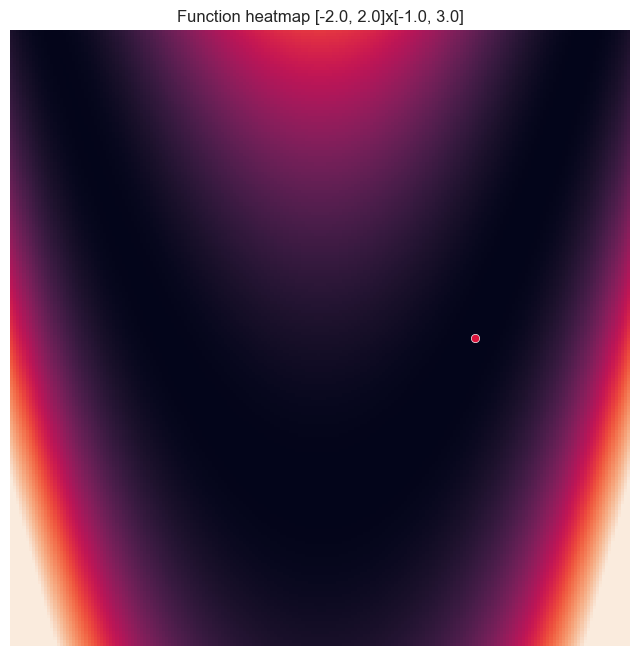

In [10]:
drawHeatmap(rosenbrockFunction, center, delta=delta)
drawPath([], center=center, minimum=minimum, delta=delta)

In [11]:
x0, y0 = -0.3, 2.2
iter = 70000
lr = 1e-4

In [12]:
history = []
lossAdam = []
x, y = sg.Variable(x0), sg.Variable(y0)
f = rosenbrockFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.Adam(model=f, variables=[x, y], lr=lr, betta1=0.9, betta2=0.998)
for i in tqdm(range(iter)):
    history.append((x.scalar, y.scalar))
    lossAdam.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
    optimizer.lr = lr - (lr - lr / 10) / iter * i
    if lossAdam[-1] < 1e-4:
        break

  0%|          | 0/70000 [00:00<?, ?it/s]

In [13]:
lossGd = []
historyGd = []
x, y = sg.Variable(x0), sg.Variable(y0)
f = rosenbrockFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.GD(model=f, variables=[x, y], lr=lr)
for i in tqdm(range(iter)):
    historyGd.append((x.scalar, y.scalar))
    lossGd.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
    if lossGd[-1] < 1e-4:
        break

  0%|          | 0/70000 [00:00<?, ?it/s]

In [14]:
lossMomentum = []
historyMomentum = []
x, y = sg.Variable(x0), sg.Variable(y0)
f = rosenbrockFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.Momentum(model=f, variables=[x, y], lr=lr, betta=0.97)
for i in tqdm(range(iter)):
    historyMomentum.append((x.scalar, y.scalar))
    lossMomentum.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
    if lossMomentum[-1] < 1e-4:
        break

  0%|          | 0/70000 [00:00<?, ?it/s]

In [15]:
lossRms = []
historyRms = []
x, y = sg.Variable(x0), sg.Variable(y0)
f = rosenbrockFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.RMSProp(model=f, variables=[x, y], lr=lr, betta=0.995)
for i in tqdm(range(iter)):
    historyRms.append((x.scalar, y.scalar))
    lossRms.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
    if lossRms[-1] < 1e-4:
        break

  0%|          | 0/70000 [00:00<?, ?it/s]

In [16]:
lossRms = []
historyRms = []
x, y = sg.Variable(x0), sg.Variable(y0)
f = rosenbrockFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.RMSProp(model=f, variables=[x, y], lr=lr, betta=0.995)
for i in tqdm(range(iter)):
    historyRms.append((x.scalar, y.scalar))
    lossRms.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
    if lossRms[-1] < 1e-4:
        break

  0%|          | 0/70000 [00:00<?, ?it/s]

In [29]:
lossNewt = []
historyNewt = []
x, y = sg.Variable(x0), sg.Variable(y0)
f = rosenbrockFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.Newton(model=f, variables=[x, y])
for i in tqdm(range(iter)):
    historyNewt.append((x.scalar, y.scalar))
    f.forward()
    f.zeroGrad()
    f.backward()
    lossNewt.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
    if lossNewt[-1] < 1e-4:
        break

  0%|          | 0/70000 [00:00<?, ?it/s]

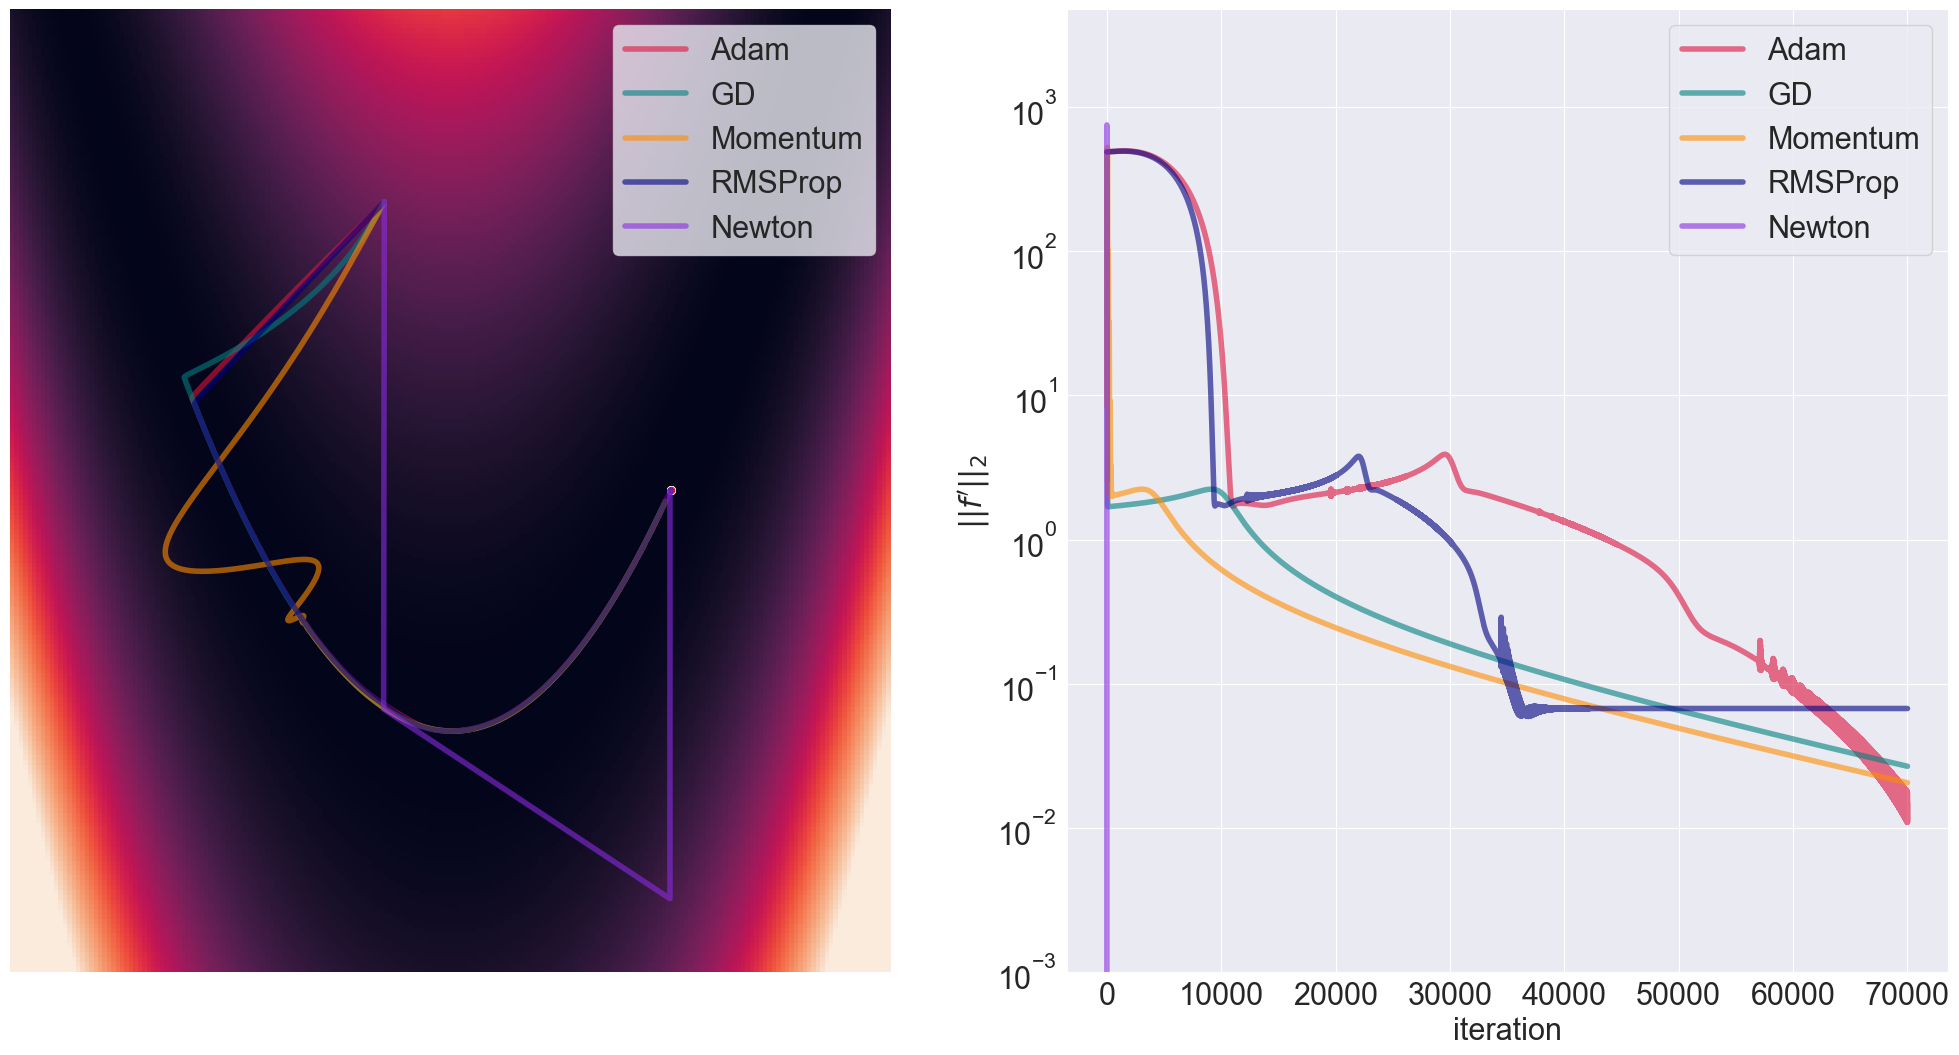

In [35]:
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 22})
delta=2
fig, ax = plt.subplots(1, 2, figsize=(25, 25/2))
drawHeatmap(rosenbrockFunction, center, delta=delta, ax=ax[0])
drawPath(history, minimum=minimum, center=center, delta=delta, ax=ax[0], color='crimson', label="Adam")
drawPath(historyGd, minimum=minimum, center=center, delta=delta, ax=ax[0], color='teal', label="GD")
drawPath(historyMomentum, minimum=minimum, center=center, delta=delta, ax=ax[0], color='darkorange', label="Momentum")
drawPath(historyRms, minimum=minimum, center=center, delta=delta, ax=ax[0], color='navy', label="RMSProp")
drawPath(historyNewt, minimum=minimum, center=center, delta=delta, ax=ax[0], color='blueviolet', label="Newton")
fig.suptitle(f"")
sns.lineplot(x=np.arange(1, len(lossAdam) + 1), y=lossAdam, ax=ax[1],
             color='crimson', label="Adam", linewidth=4, alpha=0.6)
sns.lineplot(x=np.arange(1, len(lossGd) + 1), y=lossGd, ax=ax[1],
             color='teal', label="GD", linewidth=4, alpha=0.6)
sns.lineplot(x=np.arange(1, len(lossMomentum) + 1), y=lossMomentum, ax=ax[1],
             color='darkorange', label="Momentum", linewidth=4, alpha=0.6)
sns.lineplot(x=np.arange(1, len(lossRms) + 1), y=lossRms, ax=ax[1],
             color='navy', label="RMSProp", linewidth=4, alpha=0.6)
sns.lineplot(x=np.arange(1, len(lossNewt) + 1), y=lossNewt, ax=ax[1],
             color='blueviolet', label="Newton", linewidth=4, alpha=0.6)
ax[1].set_title("")
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("$||f'||_2$")
ax[1].set_yscale('log')
ax[1].set_ylim(1e-3, None)
ax[0].legend()
None
